In [1]:
import numpy as np
import pandas as pd
import json
import collections
from collections import defaultdict 
from functools import partial
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [18]:
multi_visit_mimic_dir = '/home/asem/GP/ehr-data/mimic4-cohort'

patients = pd.read_csv(f'{multi_visit_mimic_dir}/patients.csv.gz')
admissions = pd.read_csv(f'{multi_visit_mimic_dir}/admissions.csv.gz')
diagnoses_icd = pd.read_csv(f'{multi_visit_mimic_dir}/diagnoses_icd.csv.gz', dtype = {'icd_code': str})
procedures_icd = pd.read_csv(f'{multi_visit_mimic_dir}/procedures_icd.csv.gz', dtype = {'icd_code': str})

In [19]:
diagnoses_icd

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
...,...,...,...,...,...
4063298,19999840,26071774,3,34590,9
4063299,19999840,26071774,4,43811,9
4063300,19999840,26071774,5,4019,9
4063301,19999840,26071774,6,2724,9


In [20]:
admissions

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347851,19999784,29956342,2121-01-31 00:00:00,2121-02-05 12:44:00,NaN,ELECTIVE,PHYSICIAN REFERRAL,HOME,Medicaid,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,NaN,NaN,0
347852,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0
347853,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaN,EW EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2147-07-17 17:18:00,2147-07-18 17:34:00,0
347854,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,EW EMER.,EMERGENCY ROOM,DIED,Other,ENGLISH,WIDOWED,WHITE,2164-09-10 11:09:00,2164-09-10 14:46:00,1


In [21]:
admit = pd.to_datetime(admissions['admittime'], infer_datetime_format=True).dt.normalize() 
disch = pd.to_datetime(admissions['dischtime'], infer_datetime_format=True).dt.normalize()
admissions['days'] = (disch - admit).dt.days
admissions

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,days
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,1
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,1
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0,2
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,2
4,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347851,19999784,29956342,2121-01-31 00:00:00,2121-02-05 12:44:00,NaN,ELECTIVE,PHYSICIAN REFERRAL,HOME,Medicaid,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,NaN,NaN,0,5
347852,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0,10
347853,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaN,EW EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2147-07-17 17:18:00,2147-07-18 17:34:00,0,17
347854,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,EW EMER.,EMERGENCY ROOM,DIED,Other,ENGLISH,WIDOWED,WHITE,2164-09-10 11:09:00,2164-09-10 14:46:00,1,7


In [22]:
longest_admission = {}
for subject_id, subject_df in admissions.groupby('subject_id'):
    longest_admission[subject_id] = subject_df.days.max()
    
admissions['max_days'] = admissions.subject_id.map(longest_admission)
subjects = list(set(admissions.subject_id))
longest_admission_df = pd.DataFrame({'subject_id': subjects,
                                    'longest_admission': map(longest_admission.get, subjects)})

<AxesSubplot:xlabel='days', ylabel='Count'>

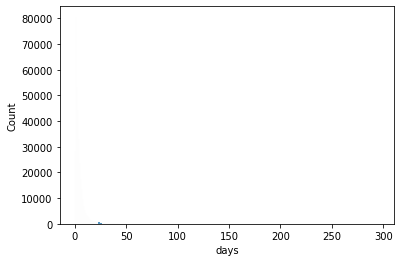

In [23]:
sns.histplot(data=admissions, x="days")

array([[<AxesSubplot:title={'center':'days'}>]], dtype=object)

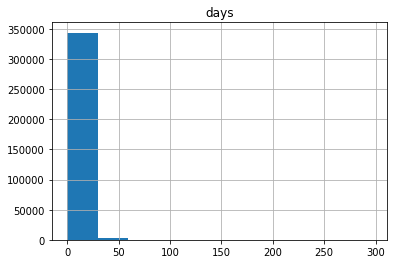

In [24]:
admissions.hist('days')

In [25]:
np.mean(admissions.max_days <= 14)

0.751471873418886

<AxesSubplot:xlabel='longest_admission', ylabel='Count'>

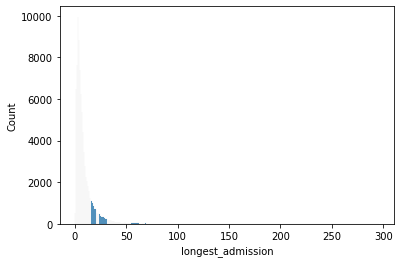

In [26]:
sns.histplot(data=longest_admission_df, x="longest_admission")

In [27]:
np.mean(longest_admission_df.longest_admission <= 14)

0.8451157962558614

In [28]:
len(subjects)

83811

In [29]:
np.mean(longest_admission_df.longest_admission <= 14) * len(subjects)

70830.0

In [30]:
subjects_2wks = set(longest_admission_df[longest_admission_df.longest_admission <= 14].subject_id)

In [31]:
len(subjects_2wks)

70830

In [32]:
patients_2wks = patients[patients.subject_id.isin(subjects_2wks)].reset_index(drop=True)
admissions_2wks = admissions[admissions.subject_id.isin(subjects_2wks)].reset_index(drop=True)
diagnoses_icd_2wks = diagnoses_icd[diagnoses_icd.hadm_id.isin(admissions_2wks.hadm_id)].reset_index(drop=True)
procedures_icd_2wks = procedures_icd[procedures_icd.hadm_id.isin(admissions_2wks.hadm_id)].reset_index(drop=True)

In [33]:
print('#admissions per patient', len(admissions_2wks) / len(patients_2wks))
print('days between admissions')
admissions_2wks['days'].describe()

#admissions per patient 3.690583086262883
days between admissions


count    261404.000000
mean          3.219997
std           2.884402
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          14.000000
Name: days, dtype: float64

In [34]:
patients_2wks.to_csv(f'{multi_visit_mimic_dir}/static_df.csv.gz', compression='gzip', index=False)
admissions_2wks.to_csv(f'{multi_visit_mimic_dir}/adm_df.csv.gz', compression='gzip', index=False)
diagnoses_icd_2wks.to_csv(f'{multi_visit_mimic_dir}/dx_df.csv.gz', compression='gzip', index=False)
procedures_icd_2wks.to_csv(f'{multi_visit_mimic_dir}/pr_df.csv.gz', compression='gzip', index=False)

### Synthetic Sample

In [36]:
import random
import numpy as np
random.seed(42)


subjects = set(admissions_2wks.subject_id)
syn_subjects = random.sample(subjects, 150)

In [37]:
adm_syn_df = admissions_2wks.copy()
diag_syn_df = diagnoses_icd_2wks.copy()
proc_syn_df = procedures_icd_2wks.copy()
stat_syn_df = patients_2wks.copy()

In [ ]:
diag_syn_df['ICD9_CODE'] =  np.random.permutation(list(diag_syn_df['ICD9_CODE']))